<a href="https://colab.research.google.com/github/ktzh/NLPhomeworks/blob/main/Lecture03_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задачи к Лекции 3

__Исходные данные__

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/mlbootcamp5_train.csv",
                 sep=";",
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,True,False,False,True,False,False,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,False,False,True,True,False,False,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,False,False,True,True,False,False,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,True,False,False,True,False,False,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,True,False,False,True,False,False,0


## Классы в Python

Нередко, возникает необходимость создания объектов с каким-нибудь внутренним поведением и состоянием. Примерами таких объектов являются классификаторы sklearn, массивы numpy и много другое. Такой объект можно объявить с помощью ключевого слова **class**

```python
class SomeObject:
    def __init__(self, depth): #тип
        self.a = depth
        self.target = None
        
    def fit(self, data, target): #структура
        self.target = data
        # magic
        return
    
    def predict(self, data):
        return self.target    
```

После этого в коде можно будет создать экземпляр данного класса
```python
a = SomeObject(depth=5)
a.fit(data, target)
a.predict(data)
```

## Задачи

**1. В sklearn на данный момент отсутствует функционал для построения деревьев решений из категориальных данных, поэтому его нужно сделать самостоятельно и проверить его работу. Что нужно сделать:**

* __создать классификатор используя только pandas, numpy и scipy. Необходимо его сделать самому, используя исключительно только numpy, pandas и scipy (запрещено использовать sklearn и прочие библиотеки). Напоминаю, что для категориальных данных операция < или > не имеют смысла (использовать только != и ==). Гиперпараметром данного классификатора должна быть максимальная глубина дерева.__
* __Проверить работу данного классификатора на наборе ("gender", "cholesterol", "gluc").__
* __С помощью кросс-валидации найти оптимальную глубину этого дерева. Для вашего классификатора GridSearchCV не подойдет, придется это сделать также самостоятельно.__
* __Нарисовать полученное дерево (я должен понять, как и откуда вы его нарисовали).__

Алгоритм работы классификатора:
 1. Перебираем все возможные признаки и смотрим либо неопределенность Джини, либо прирост информации. Это даст критерий разбиения в виде "признак == значение"
 2. Если выборка полученная при разбиении состоит из объектов одного класса (соответсвует нулевой энтропии), то данный лист просто возвращает значение этого класса.
 3. В противном случае, образуется новый узел и для него начинаем с пункта 1.
 4. Если достигли максимальной глубины, то вместа узла создаем лист, который возвращает самое вероятное значение.

__Замечание:__ в этой задаче не нужно использовать onehot-кодирование.

In [2]:
import numpy as np
from collections import Counter
from scipy.stats import mode

class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, *, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label

    def is_leaf(self):
        return self.label is not None


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y, depth=0):
        n_samples, n_features = X.shape
        num_labels = len(np.unique(y))

        if num_labels == 1 or (self.max_depth is not None and depth >= self.max_depth):
            leaf_label = mode(y)[0][0]
            return Node(label=leaf_label)

        best_feature, best_value = self._best_split(X, y)

        if best_feature is None:
            leaf_label = mode(y)[0][0]
            return Node(label=leaf_label)

        # Разбиваем данные
        idx_left = X[best_feature] == best_value
        idx_right = ~idx_left

        left_subtree = self.fit(X[idx_left], y[idx_left], depth + 1)
        right_subtree = self.fit(X[idx_right], y[idx_right], depth + 1)

        return Node(feature=best_feature, value=best_value,
                    left=left_subtree, right=right_subtree)

    def _best_split(self, X, y):
        best_gain = -np.inf
        best_feature, best_value = None, None
        n_samples = len(y)

        for feature in X.columns:
            values = X[feature].unique()
            for value in values:
                mask = X[feature] == value
                gain = self._information_gain(y, mask, y[~mask])
                if gain > best_gain:
                    best_gain = gain
                    best_feature, best_value = feature, value
        return best_feature, best_value

    def _gini(self, y):
        proportions = np.array(list(Counter(y).values())) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _information_gain(self, y, left_mask, right_mask):
        y_left = y[left_mask]
        y_right = y[right_mask]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0

        n = len(y)
        gini_parent = self._gini(y)
        gini_left = self._gini(y_left)
        gini_right = self._gini(y_right)

        gain = gini_parent - (len(y_left)/n)*gini_left - (len(y_right)/n)*gini_right
        return gain

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for _, x in X.iterrows()])

    def _predict_one(self, x, node):
        if node.is_leaf():
            return node.label

        if x[node.feature] == node.value:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import mode

class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y, depth=0):
        if (self.max_depth is not None and depth >= self.max_depth) or len(np.unique(y)) == 1:
            self.label = self._most_common_label(y)
            self.is_leaf = True
            return

        best_feature, best_value = self._find_best_split(X, y)
        if best_feature is None:
            self.label = self._most_common_label(y)
            self.is_leaf = True
            return

        self.feature = best_feature
        self.value = best_value
        self.is_leaf = False

        left_mask = X[best_feature] <= best_value
        self.left = DecisionTreeClassifier(max_depth=self.max_depth)
        self.left.fit(X[left_mask], y[left_mask], depth + 1)

        self.right = DecisionTreeClassifier(max_depth=self.max_depth)
        self.right.fit(X[~left_mask], y[~left_mask], depth + 1)

    def _most_common_label(self, y):
        try:
            return mode(y).mode[0]
        except IndexError:
            return y.iloc[0] if hasattr(y, 'iloc') else y[0]

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_value = None

        for feature in X.columns:
            values = np.sort(X[feature].unique())
            for value in values:
                left_mask = X[feature] <= value
                right_mask = ~left_mask

                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                gini = self._gini_impurity(y[left_mask], y[right_mask])

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def _gini_impurity(self, left_y, right_y):
        n_left, n_right = len(left_y), len(right_y)
        n_total = n_left + n_right

        if n_left == 0 or n_right == 0:
            return float('inf')

        p_left = np.sum(left_y == self._most_common_label(left_y)) / n_left
        p_right = np.sum(right_y == self._most_common_label(right_y)) / n_right

        gini_left = 1 - p_left**2
        gini_right = 1 - p_right**2

        weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right
        return weighted_gini

    def predict(self, X):
        return np.array([self._predict_row(row) for _, row in X.iterrows()])

    def _predict_row(self, row):
        if hasattr(self, 'is_leaf') and self.is_leaf:
            return self.label

        if row[self.feature] <= self.value:
            return self.left._predict_row(row)
        else:
            return self.right._predict_row(row)

def print_tree(node, depth=0, prefix=""):
    indent = "    " * depth
    if hasattr(node, 'is_leaf') and node.is_leaf:
        print(f"{indent}{prefix}-> Label: {node.label}")
    else:
        print(f"{indent}{prefix}If {node.feature} <= {node.value}:")
        print_tree(node.left, depth + 1, prefix="Yes ")
        print(f"{indent}Else:")
        print_tree(node.right, depth + 1, prefix="No  ")

df = pd.read_csv("/content/mlbootcamp5_train.csv", sep=";", index_col="id")
X = df[['gender', 'cholesterol', 'gluc']]
y = df['cardio']

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X, y)

print("\nСтруктура дерева:\n")
print_tree(tree)

sample = X.iloc[0:1]
pred = tree.predict(sample)
print("\nПредсказание для первого образца:", pred[0])



Структура дерева:

If cholesterol <= 1:
    Yes If gluc <= 1:
        Yes If gender <= 1:
            Yes -> Label: 0
        Else:
            No  -> Label: 0
    Else:
        No  If gluc <= 2:
            Yes -> Label: 0
        Else:
            No  -> Label: 0
Else:
    No  If gender <= 1:
        Yes If gluc <= 2:
            Yes -> Label: 1
        Else:
            No  -> Label: 1
    Else:
        No  If gluc <= 1:
            Yes -> Label: 1
        Else:
            No  -> Label: 1

Предсказание для первого образца: 0


**Комментарии:** Ваши комментарии здесь.

In [6]:
!pip install graphviz

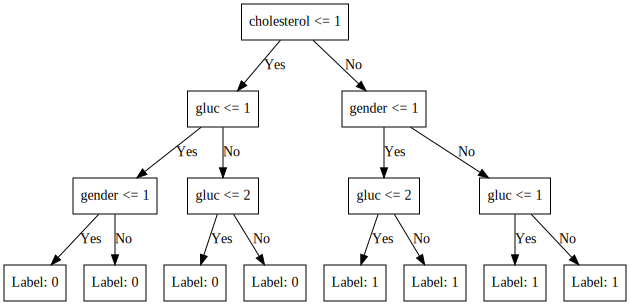

In [7]:
from graphviz import Digraph

def visualize_tree(tree, feature_names=None):
    dot = Digraph()
    dot.attr('node', shape='box')

    def add_node(node, parent_id=None, edge_label=""):
        node_id = str(id(node))

        if hasattr(node, 'is_leaf') and node.is_leaf:
            label = f"Label: {node.label}"
            dot.node(node_id, label=label)
        else:
            label = f"{node.feature} <= {node.value:.2f}" if isinstance(node.value, float) else f"{node.feature} <= {node.value}"
            dot.node(node_id, label=label)

        if parent_id is not None:
            dot.edge(parent_id, node_id, label=edge_label)

        if hasattr(node, 'left'):
            add_node(node.left, node_id, "Yes")
        if hasattr(node, 'right'):
            add_node(node.right, node_id, "No")

    add_node(tree)
    return dot

# Визуализация дерева
visual_tree = visualize_tree(tree)
visual_tree